<a href="https://colab.research.google.com/github/Anjasfedo/Learning-TensorFlow/blob/main/eat_tensorflow2_in_30_days/Chapter5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5-2 feature_column

Feature column is usually applied in the feature engineering for the structured data, while rarely used for the image for text date.

## Introduction about how to use feature column

Feature column is used to converting category features into one-hot encoding, or creating bucketing feature from continous feature, or generating cross features from multiple features, etc.

Before creating feature column, please call the function in the module `tf.feature_column`. There is nine most frequently used function in this module. All these functions will return a Categorical-Column or a Dense-Column object, but will not return bucketized_column, since the last class is inherited from the first two classes.

Be careful: all the Categorical-Column class have to be converted into Dense-Column class through `indicator_column` before input to the model

- `numeric_column`, the most frequently used function.
- `bucketize_column`, genrated from numerical, listing multiple features from a numerical column; it is one-hot encoded.
- `categorical_column_with_identity`, one-hot encoded, identical to the case that each bucket is one integer.
- `categorical_column_with_vocabulary_list`, one-hot encoded; the dictionary is specified by the list.
- `categorical_column_with_vocabulary_file`, one-hot encoded; the dictionary is specified by the file.
- `categorical_column_with_hash_bucket`, used in the case with a large integer or a large dictionary.
- `indicator_column`, generated by Categorical-Column; one-hot encoded.
- `embedding_column`, generated by Categorical-Column; the embedded vector distributed parameter needs learning/training. The recommended dimension of the embedded vector is the fourth root to the number of categories.
- `crossed_column`, consist of aribatry category column except for `categorical_column_with_hash_bucket`.

## 2. Demonstration of feature column

Here is a complete examle that solves Titanic survival problem using feature column.

In [24]:
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models

In [25]:
# Print log
def printlog(info):
  nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  print("\n"+"=========="*8 + "%s"%nowtime)
  print(info+'...\n\n')

In [26]:
# Construct data pipeline
printlog('step 1: prepare dataset')

df_train_raw = pd.read_csv('https://raw.githubusercontent.com/lyhue1991/eat_tensorflow2_in_30_days/master/data/titanic/train.csv')
df_test_raw = pd.read_csv('https://raw.githubusercontent.com/lyhue1991/eat_tensorflow2_in_30_days/master/data/titanic/test.csv')

df_raw = pd.concat([df_train_raw, df_test_raw])

def prepare_dfdata(df_raw):
  df_data = df_raw.copy()
  df_data.columns = [x.lower() for x in df_data.columns]
  df_data = df_data.rename(columns={'survived':'label'})
  df_data = df_data.drop(['passengerid', 'name'], axis=1)

  for col, dtype in dict(df_data.dtypes).items():
    # See the missing values
    if df_data[col].hasnans:
      # Adding sign to the missing value
      df_data[col + '_nan'] = pd.isna(df_data[col]).astype('int32')

      # Replace missing values with the mean
      if dtype == np.dtype('float64'):
        df_data[col].fillna(df_data[col].mean(), inplace=True)
      else:
        df_data[col].fillna('', inplace=True)

  return (df_data)

df_data = prepare_dfdata(df_raw)
df_train = df_data.iloc[0:len(df_train_raw), :]
df_test = df_data.iloc[len(df_train_raw):, :]

# Import data from dataframe
def df_to_dataset(df, shuffle=True, batch_size=32):
  df_data = df.copy()

  if 'label' not in df_data.columns:
    ds = tf.data.Dataset.from_tensor_slices(df_data.to_dict(orient='list'))
  else:
    labels = df_data.pop('label')
    ds = tf.data.Dataset.from_tensor_slices((df_data.to_dict(orient='list'), labels))

  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))

  ds = ds.batch(batch_size)

  return ds

ds_train = df_to_dataset(df_train)
ds_test = df_to_dataset(df_test)


================================================================================2024-07-24 04:27:15
step 1: prepare dataset...




In [27]:
# Definint the feature column
printlog('step 2: define feature column')

feature_columns = []

# numeric columns
for col in ['age', 'fare', 'parch', 'sibsp'] + [c for c in df_data.columns if c.endswith('_nan')]:
  feature_columns.append(tf.feature_column.numeric_column(col))

# bucketized columns
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# Category column
# All the categorical-Column class have to converted into Dense-Column class through `indicator_column` before intpu to the model.
sex = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('sex', ['male', 'female']))
feature_columns.append(sex)

pclass = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('pclass', [1, 2, 3]))
feature_columns.append(pclass)

ticket = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_hash_bucket('ticket', 1000))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('embarked', ['S', 'C', 'Q']))
feature_columns.append(embarked)

# embedding columns
cabin = tf.feature_column.embedding_column(tf.feature_column.categorical_column_with_hash_bucket('cabin', 1000), dimension=8)
feature_columns.append(cabin)

# Croessed column
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list('pclass', [1, 2, 3])
crossed_feature = tf.feature_column.indicator_column(tf.feature_column.crossed_column([age_buckets, pclass_cate], hash_bucket_size=15))
feature_columns.append(crossed_feature)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.k


================================================================================2024-07-24 04:29:52
step 2: define feature column...




In [28]:
# Defining the model
printlog('step 3: define model')

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
  layers.DenseFeatures(feature_columns), # Placing the feature into tf.keras.layers.DenseFeatures
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])


================================================================================2024-07-24 04:30:25
step 3: define model...




In [29]:
# Training the model
printlog('step 4: training')

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(ds_train,
                    validation_data=ds_test,
                    epochs=10)


================================================================================2024-07-24 04:30:39
step 4: training...


Epoch 1/10
23/23 [==============================] - 3s 27ms/step - loss: 0.6261 - accuracy: 0.6854 - val_loss: 0.6000 - val_accuracy: 0.6983
Epoch 2/10
23/23 [==============================] - 0s 5ms/step - loss: 0.5786 - accuracy: 0.7093 - val_loss: 0.5919 - val_accuracy: 0.6927
Epoch 3/10
23/23 [==============================] - 0s 5ms/step - loss: 0.5432 - accuracy: 0.7317 - val_loss: 0.5310 - val_accuracy: 0.7151
Epoch 4/10
23/23 [==============================] - 0s 5ms/step - loss: 0.5107 - accuracy: 0.7556 - val_loss: 0.4959 - val_accuracy: 0.7765
Epoch 5/10
23/23 [==============================] - 0s 7ms/step - loss: 0.4794 - accuracy: 0.7907 - val_loss: 0.4935 - val_accuracy: 0.7430
Epoch 6/10
23/23 [==============================] - 0s 5ms/step - loss: 0.4746 - accuracy: 0.8174 - val_loss: 0.4631 - val_accuracy: 0.7765
Epoch 7/10
23/23 [==================


================================================================================2024-07-24 04:31:44
step 5: evaluating...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatu  multiple                  8000      
 res)                                                            
                                                                 
 dense (Dense)               multiple                  67200     
                                                                 
 dense_1 (Dense)             multiple                  4160      
                                                                 
 dense_2 (Dense)             multiple                  65        
                                                                 
Total params: 79425 (310.25 KB)
Trainable params: 79425 (310.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________

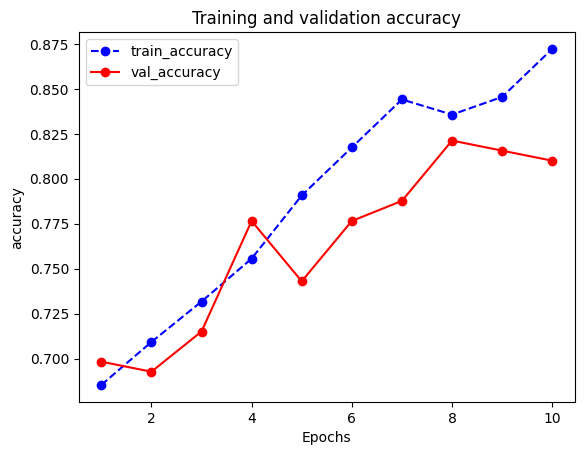

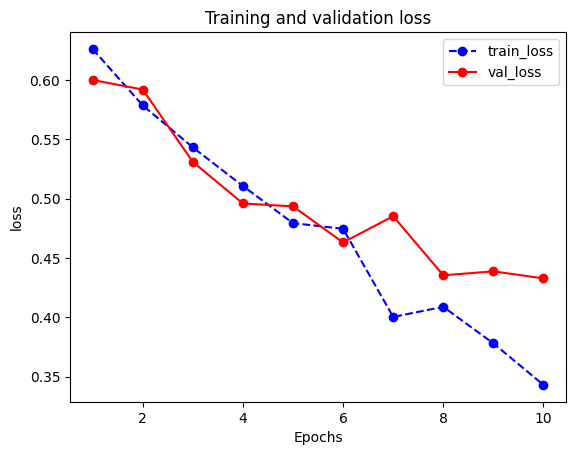

In [31]:
# Evaluating the model
printlog('step 5: evaluating')

model.summary()

def plot_metric(history, metric):
  train_metrics = history.history[metric]
  val_metrics = history.history['val_'+metric]

  epochs = range(1, len(train_metrics) + 1)

  plt.plot(epochs, train_metrics, 'bo--')
  plt.plot(epochs, val_metrics, 'ro-')
  plt.title('Training and validation '+ metric)
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend(['train_'+metric, 'val_'+metric])
  plt.show()

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')